In [ ]:
import torch
import sys

In [ ]:
# Install a pip package in the current Jupyter kernel
!{sys.executable} -m pip install transformers
!{sys.executable} -m pip install textstat
!{sys.executable} -m pip install seaborn

In [ ]:
import os
import time
import datetime
import seaborn as sns

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

In [ ]:
from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

In [ ]:
torch.cuda.is_available()

In [ ]:
!nvidia-smi

In [ ]:
print(os.path)

In [ ]:
import collections
import textstat
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

class Util:

    def stem(self, word_to_stem: str):
        ps = PorterStemmer()
        return ps.stem(word_to_stem)

class Book:
    book_title = ""
    book_text = []

    def tikify(self, level: str):
        return "tikified"

class FileIO:

    def load_level_vocab(self, reading_level: int):
        utils = Util()
        level_appropriate_words = {}

        # level-appropriate words include all levels UP to the one passed in
        for i in range(0, reading_level + 1):
            words_file = open(os.path.abspath("data/" + "words_" + str(i) + ".txt"))
            for line in words_file:
                if len(line) > 1 and not line.startswith("@"):
                    # skip processing empty and copyright lines
                    words_trimmed_spaces = line.replace("  ", " ")
                    words = words_trimmed_spaces.split(" ")
                
                    for word in words:
                        level_appropriate_words[utils.stem(word)] = utils.stem(word)

        return level_appropriate_words

    def load_cbt_train_data(self):
        all_books = {}
        new_book = Book()

        cbt_file = open(os.path.abspath("data/cbt_train.txt"))
        for line in cbt_file:
            if line.startswith("_BOOK_TITLE_"):
                # skip the very beginning of the file - no book data yet
                if len(new_book.book_title) > 0:
                    all_books[new_book.book_title] = Book()
                    all_books[new_book.book_title].book_title = new_book.book_title
                    all_books[new_book.book_title].book_text = new_book.book_text
                    
                # start a new book
                new_book_title = line.replace("_BOOK_TITLE_ : ", "")
                new_book.book_title = new_book_title.rstrip()
                new_book.book_text = []

            else:
                #keep appending to book
                new_book.book_text.append(line)

        return all_books

In [ ]:
utils = Util()
file_io = FileIO()

def __init__(desired_reading_level):
    # mainly kick off the pipeline using the command-line args passed in
    # desired_reading_level = sys.argv[1]
    kick_off_text_gen_pipeline(int(desired_reading_level))


def kick_off_text_gen_pipeline(desired_reading_level):
    # load training data
    train_data = file_io.load_cbt_train_data()
    # baseline it to the desired level
    baseline(train_data, desired_reading_level)


def baseline(train_data: dict, reading_level: int):

    k_lvl = file_io.load_level_vocab(reading_level)

    book_title = "Lewis_Carroll___Alice's_Adventures_Under_Ground.txt.out"
    # unaltered training text
    print("BOOK TITLE xxx'" + str(book_title) + "'xxx")
    #print("BOOK TEXT " + str(train_data[book_title].book_text))
    print("Total length " + str(sum(len(word) for word in train_data[book_title].book_text)))

    # remove all words but the k-level (stemmed) and kept all the capitalized words as named entities
    leveled_book_text = []
    for sentence in train_data[book_title].book_text:
        original_sentence_readability_score = textstat.flesch_kincaid_grade(sentence)
        print("ORIGINAL sentence " + str(sentence))
        print("ORIGINAL sentence readability score " + str(original_sentence_readability_score))
        leveled_sentence = ""
        for word in sentence.split():
            if utils.stem(word) in k_lvl or word[0].isupper():
                 leveled_sentence += word + " "
        leveled_book_text.append(leveled_sentence)
        leveled_sentence_readability_score = textstat.flesch_kincaid_grade(leveled_sentence)
        print("LEVELED sentence " + str(leveled_sentence))
        print("LEVELED sentence readability score " + str(leveled_sentence_readability_score))

    train_data[book_title].book_text = leveled_book_text
    print("LEVELED BOOK TITLE xxx'" + str(book_title) + "'xxx")
    #print("LEVELED BOOK TEXT " + str(train_data[book_title].book_text))
    print("LEVELED Total length " + str(sum(len(word) for word in train_data[book_title].book_text)))

def baseline_sentence_list(train_data: list, reading_level: int):

    k_lvl = file_io.load_level_vocab(reading_level)

    # remove all words but the k-level (stemmed) and kept all the capitalized words as named entities
    leveled_book_text = []
    for sentence in train_data:
        original_sentence_readability_score = textstat.flesch_kincaid_grade(sentence)
        leveled_sentence = ""
        for word in sentence.split():
            if utils.stem(word) in k_lvl or word[0].isupper():
                 leveled_sentence += word + " "
        leveled_book_text.append(leveled_sentence)
        leveled_sentence_readability_score = textstat.flesch_kincaid_grade(leveled_sentence)

    return leveled_book_text


<AxesSubplot:ylabel='Count'>

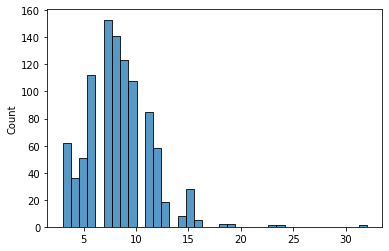

In [34]:
# load text of all books
train_data = file_io.load_cbt_train_data()
# get just Lucy Maud Montgomery's short stories since she has the most sentences with accessible readability for kids
book_title = "Lucy_Maud_Montgomery___Lucy_Maud_Montgomery_Short_Stories,_1909_to_1922.txt.out"
lucy_maud_sentences = train_data[book_title].book_text

# plot sentence lengths
sentence_lengths = []
grade_level_3_sentences = []

for sentence in lucy_maud_sentences:
    readability_score = textstat.flesch_kincaid_grade(sentence)
    if readability_score < 3:
        grade_level_3_sentences.append(sentence)
        # get rough token count distribution
        tokens = nltk.word_tokenize(sentence)
        sentence_lengths.append(len(tokens))

sentence_lengths = np.array(sentence_lengths)
sns.histplot(data=sentence_lengths)

In [35]:
np.average(sentence_lengths)

8.314572864321608

In [ ]:
# The GPT-2 Text Generation Code that follows was heavily borrowed from https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=x0WeP5PREUuy
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

In [ ]:
batch_size = 2

class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
dataset = GPT2Dataset(grade_level_3_sentences, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Not really doing anything special with the config
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# some parameters I cooked up that work reasonably well

epochs = 2
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        model.zero_grad()        
        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  
        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            model.train()
            
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
# save model
output_dir = './model_lucy_maud_level_13_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

In [ ]:
model.eval()
prompt = "<|startoftext|>"

# encode context the generation is conditioned on
input_ids = torch.tensor(tokenizer.encode('<|startoftext|>Baby Shark')).unsqueeze(0)
input_ids = input_ids.to(device)

# generate text until the output length (which includes the context length) reaches 300
greedy_output = model.generate(input_ids, max_length=300, do_sample=True, top_k=0, num_return_sequences=5)
for i, greedy_output in enumerate(greedy_output):
  print("Greedy: {}: {}\n\n".format(i, tokenizer.decode(greedy_output, skip_special_tokens=True)))

# activate beam search and early_stopping
beam_output = model.generate( input_ids, max_length=500, num_beams=1, do_sample=True, top_k=0, num_return_sequences=5)
for i, beam_output in enumerate(beam_output):
    print("Beam: {}: {}\n\n".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))


In [ ]:
# EXPERIMENTS with Lucy Maud Montgomery
# Load text, load models and baseline
# get just Lucy Maud Montgomery's short stories since she has the most sentences with accessible readability for kids
alice_in_wonderland_book = "Lucy_Maud_Montgomery___Lucy_Maud_Montgomery_Short_Stories,_1909_to_1922.txt.out"
alice_in_wonderland_sentences = train_data[alice_in_wonderland_book].book_text[0:10]

print("Original Text: First 10 sentences")
print (' '.join(alice_in_wonderland_sentences).replace('\n', ' '))

# Readability test works on individual sentences, so average that out
avg_reading_lvl = sum([textstat.flesch_kincaid_grade(x) for x in alice_in_wonderland_sentences])/len(alice_in_wonderland_sentences)
print("\nEstimated Average Reading Level (Flesch Kincaid grade) " + str(avg_reading_lvl))

In [ ]:
print("Baseline Text for Level K (Kindergarten): First 10 sentences")
alice_in_wonderland_baseline_3 = baseline_sentence_list(alice_in_wonderland_sentences, 0)
print (' '.join(alice_in_wonderland_baseline_3).replace('\n', ' '))

# Readability test works on individual sentences, so average that out
avg_reading_lvl = sum([textstat.flesch_kincaid_grade(x) for x in alice_in_wonderland_baseline_3])/len(alice_in_wonderland_baseline_3)
print("\nEstimated Average Reading Level (Flesch Kincaid grade) " + str(avg_reading_lvl))

In [ ]:
print("Generated Text for Level K (Kindergarten): First 10 sentences")

# Load the pre-saved model
#configuration3 = GPT2Config.from_pretrained('./model_lucy_maud_level3_save/', output_hidden_states=False)
#model3 = GPT2LMHeadModel.from_pretrained('./model_lucy_maud_level3_save/', config=configuration)
#model3 = model3.to(device)

generated_for_k_level = []
# for each sentence, take the first 3 words and generate the rest, appropriate for the level
for sentence in alice_in_wonderland_sentences:
    first_3_words = ' '.join(sentence.split()[:3])
    tokenized_first_3_words = torch.tensor(tokenizer.encode('<|startoftext|>' + first_3_words)).unsqueeze(0)
    tokenized_first_3_words = tokenized_first_3_words.to(device)
    greedy_alice = model.generate(tokenized_first_3_words, max_length=300, do_sample=True, top_k=0, num_return_sequences=1)
    generated_for_k_level.append((tokenizer.decode(greedy_alice[0], skip_special_tokens=True)).replace("\n", " "))

print (' '.join(generated_for_k_level))

# Readability test works on individual sentences, so average that out
avg_reading_lvl = sum([textstat.flesch_kincaid_grade(x) for x in generated_for_k_level])/len(generated_for_k_level)
print("\nEstimated Average Reading Level (Flesch Kincaid grade) " + str(avg_reading_lvl))
    

In [ ]:
print("Generated Text for Level 13 (High School): First 10 sentences")

# Load pre-saved model
configuration13 = GPT2Config.from_pretrained('./model_lucy_maud_level_13_save/', output_hidden_states=False)
model13 = GPT2LMHeadModel.from_pretrained('./model_lucy_maud_level_13_save/', config=configuration)
model13 = model13.to(device)

generated_for_k_level = []
# for each sentence, take the first 3 words and generate the rest, appropriate for the level
for sentence in alice_in_wonderland_sentences:
    first_3_words = ' '.join(sentence.split()[:3])
    tokenized_first_3_words = torch.tensor(tokenizer.encode('<|startoftext|>' + first_3_words)).unsqueeze(0)
    tokenized_first_3_words = tokenized_first_3_words.to(device)
    greedy_alice = model.generate(tokenized_first_3_words, max_length=300, do_sample=True, top_k=0, num_return_sequences=1)
    generated_for_k_level.append((tokenizer.decode(greedy_alice[0], skip_special_tokens=True)).replace("\n", " "))

print (' '.join(generated_for_k_level))

# Readability test works on individual sentences, so average that out
avg_reading_lvl = sum([textstat.flesch_kincaid_grade(x) for x in generated_for_k_level])/len(generated_for_k_level)
print("\nEstimated Average Reading Level (Flesch Kincaid grade) " + str(avg_reading_lvl))